Door Dennis Besselsen, Levi Verhoef, Emiel Verhoef (geen familie!)
V2A, 2021 

We beginnen met het importeren van een aantal libraries:

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import pearsonr
from scipy.stats import stats
from sklearn.cluster import KMeans
import seaborn as sns
#import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
#import graphviz
from sklearn import svm
from math import sqrt


Hier lezen we onze beide databases alvast in:

In [2]:
#the film database from the assignment
table = pd.read_csv("movie.csv")

#film database we found online(https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset)
table2 =  pd.read_csv("IMDB_movies.csv", low_memory = False)


<h2>Onderzoeksvragen:</h2>

1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB?
2. In hoeverre is de IMDB score van een film te voorspellen op basis van het budget en de opbrengst?
3. Kunnen we logische klusters vinden van regisseurs die winstgevende films maken of regisseurs die vaak verliesgevende films maken?

<h1> Featurevariabelen: </h1>
We hebben een aantal featurevariabelen gekozen die passen bij onze onderzoeksvragen. Het zou altijd nog kunnen dat we bepaalde variabelen toevoegen of weglaten, maar dit is onze eerste selectie.

**director_name**: een **nominale meetwaarde** waarin de naam van de regisseur staat.
Director name heeft af en toe geen ingevulde waarde. Dat maakt voor onze onderzoeksvragen niet veel uit.

**num_voted_users**: een **discrete meetwaarde** die ons laat zien hoeveel mensen op een film hebben gestemd op IMDb.
Deze featurevariabele gebruiken we als één van onze maatstaven voor IMDb populariteit. Hoe meer mensen stemmen op een film, hoe hoger de populariteit. 
Dit is direct een handige variabele voor onze eerste onderzoeksvraag. 

**num_critic_for_reviews**: een **discrete meetwaarde** die ons laat zien hoeveel critici een film hebben gerecenseerd.
Deze featurevariabele is een andere maatstaf voor populariteit van een film op IMDb. Ook deze variabele lijkt op eerste oogopslag erg interessant voor onderzoeksvraag 1.

**num_user_for_reviews**: een **discrete meetwaarde** die ons laat zien hoeveel IMDb gebruikers een film hebben gerecenseerd.
Dit is de derde meetwaarde die IMDb populariteit aangeeft. Een review achterlaten is meer moeite dan simpelweg stemmen, 
dus wellicht dat de waardes voor deze featurevariabele zwaarder wegen of een sterkere correlatie aangeven dan de voorgaande variabelen die te maken hadden met IMDb populariteit.

**imdb_score**: een **discrete meetwaarde** die de score van een film weergeeft.
IMDB score is één van onze targetvariabelen en zodoende nemen we deze sowieso mee in onze dataset.

**movie_facebook_likes**: een **discrete meetwaarde** die de hoeveelheid likes die een film op facebook heeft weergeeft.
Movie_facebook_likes is de meetwaarde die we gebruiken om te bepalen hoe populair een film op facebook is, wat één van onze directe featurevariabelen is voor onderzoeksvraag 1.

**budget**: een **continue meetwaarde** die aangeeft hoeveel geld er is besteed aan het produceren van een film.
Budget is een meetwaarde die we sowieso interessant vonden om mee te nemen, eventueel voor onderzoeksvraag 2. 
We kwamen er al snel achter dat er een paar vreemde uitschieteres zijn, maar die zijn vrij simpel te verhelpen. Verder zullen we hier ook nog de waardes moeten normaliseren, gezien er af en toe waardes tussen zitten die in een andere munteenheid
Er zijn best veel entries in onze dataframe met null-waardes op "budget", dus we kiezen ervoor om die te droppen, gezien we deze featurevariabele centraal stellen in onze onderzoeksvraag.

**gross**: een **continue meetwaarde** die aangeeft hoeveel omzet een film heeft gedraaid.
Gross is een meetwaarde die in meerdere van onze onderzoeksvragen een vrij prominente rol speelt. 

<h2> Eerste kijk in de database met gekozen feature variabelen </h2>:

We gebruiken hier describe() om inzicht te krijgen in de centrum en spreidingsmaten van onze gekozen variabelen.

In [3]:
#trim tables so we only have feature variables
feature_table = table[['movie_title','duration', 'movie_imdb_link', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews','imdb_score', 'movie_facebook_likes','budget', 'gross', 'director_name']]

# change the movie_imdb_link to a imdb_title_id
feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]
feature_table = feature_table.rename(columns={"movie_imdb_link": "imdb_title_id"})

# Use describe function to show the central tendency and dispersion values, of only the feature variables
feature_table.describe()


<ipython-input-3-a04f1ef064f8>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]


,duration,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross
count,5028.000000,5.043000e+03,4993.000000,5022.000000,5043.000000,5043.000000,4.551000e+03,4.159000e+03
mean,107.201074,8.366816e+04,140.194272,272.770808,6.442138,7525.964505,3.975262e+07,4.846841e+07
std,25.197441,1.384853e+05,121.601675,377.982886,1.125116,19320.445110,2.061149e+08,6.845299e+07
min,7.000000,5.000000e+00,1.000000,1.000000,1.600000,0.000000,2.180000e+02,1.620000e+02
25%,93.000000,8.593500e+03,50.000000,65.000000,5.800000,0.000000,6.000000e+06,5.340988e+06
50%,103.000000,3.435900e+04,110.000000,156.000000,6.600000,166.000000,2.000000e+07,2.551750e+07
75%,118.000000,9.630900e+04,195.000000,326.000000,7.200000,3000.000000,4.500000e+07,6.230944e+07
max,511.000000,1.689764e+06,813.000000,5060.000000,9.500000,349000.000000,1.221550e+10,7.605058e+08


Een aantal observaties:
    
We hebben ~5000 films in onze eerste database. 

De budget feature mist ~10% van zijn waardes, de gross feature bijna 20%.

Alle andere features missen maar een heel klein deel van hun waardes.

In [4]:
#wij hantered hier de vuistregel dat waardes die 1.5IQR onder de Q1 liggen outliers OF 1.5IQR boven Q3 , outliers zijn.
#Ook hanteren wij hier de regel dat waardes die 3QR onder de Q1 liggen outliers OF 3IQR boven Q3 ,  STERKE outliers zijn.

#deze functie heeft 3 parameters:
#1e parameter: sterke van outliers die eruit worden gefilterd word. 
# 's' = strong, wat betekent dat dat alleen de sterke outliers er uit worden gefilterd.
# 'a' = all, wat betekent dat dat alle  outliers er uit worden gefilterd.

#De 2e parameter:
# het dataframe waar de outliers worden uitgefilterd.

#De 3e parameter:
# Een lijst kolomen waar de de outliers worden uitgefilterd. bijv ['US_gross', 'duration']

def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

#column_outlier('s',feature_table,['duration'])
print(feature_table.count())
print(column_outlier('a',feature_table,['gross','duration', 'movie_facebook_likes']).count())

movie_title               5043
duration                  5028
imdb_title_id             5043
num_voted_users           5043
num_critic_for_reviews    4993
num_user_for_reviews      5022
imdb_score                5043
movie_facebook_likes      5043
budget                    4551
gross                     4159
director_name             4939
dtype: int64
movie_title               3474
duration                  3460
imdb_title_id             3474
num_voted_users           3474
num_critic_for_reviews    3433
num_user_for_reviews      3458
imdb_score                3474
movie_facebook_likes      3474
budget                    3099
gross                     2754
director_name             3447
dtype: int64


In [5]:
feature_table.dtypes

movie_title                object
duration                  float64
imdb_title_id              object
num_voted_users             int64
num_critic_for_reviews    float64
num_user_for_reviews      float64
imdb_score                float64
movie_facebook_likes        int64
budget                    float64
gross                     float64
director_name              object
dtype: object

Zoals we in dit korte overzicht kunnen zien zijn veruit de meeste featurevariabelen die we hebben gekozen numeriek. We hebben een aantal nominale, namelijk director_name, movie_title en imdb_title_id.

Imdb_title_id gebruiken we eigenlijk vooral als primary key.

<h2>Business understanding van de data </h2>

We kunnen handmatig alvast een paar van onze variabelen checken doormiddel van business understanding.

Ik begin hier met budget. Een simpele google zoekopdracht verteld ons dat Avengers: Endgame de hoogstgebudgeteerde film ooit is met een budget van $400m usd. Alle waardes die daar boven uitkomen, zijn dus sowieso incorrect.

Als we in de database kijken kunnen we zien dat onze database nog van voor die tijd is, en de hoogstgebudgeteerde film in onze database is Pirates of the Caribbean: At World's End, met 300m USD. Er zijn 13 films met een waarde daarboven, dus daar is duidelijk of de verkeerde munteenheid gebruikt, of iets niet goed gegaan met de conversie. 

We kijken hier naar de top 30 films gesorteerd op budget:

In [6]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
feature_table.nlargest(30, 'budget')

,movie_title,duration,imdb_title_id,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross,director_name
2988,The Host,110.000,tt0468492,68883,363.000,279.000,7.000,7000,12215500000.000,2201412.000,Joon-ho Bong
3859,Lady Vengeance,112.000,tt0451094,53508,202.000,131.000,7.700,4000,4200000000.000,211667.000,Chan-wook Park
3005,Fateless,134.000,tt0367082,5603,73.000,45.000,7.100,607,2500000000.000,195888.000,Lajos Koltai
2323,Princess Mononoke,134.000,tt0119698,221552,174.000,570.000,8.400,11000,2400000000.000,2298191.000,Hayao Miyazaki
2334,Steamboy,103.000,tt0348121,13727,105.000,79.000,6.900,973,2127519898.000,410388.000,Katsuhiro Ôtomo
3423,Akira,124.000,tt0094625,106160,150.000,430.000,8.100,0,1100000000.000,439162.000,Katsuhiro Ôtomo
4542,Godzilla 2000,99.000,tt0188640,5442,107.000,140.000,6.000,339,1000000000.000,10037390.000,Takao Okawara
3075,Kabhi Alvida Naa Kehna,193.000,tt0449999,13998,20.000,264.000,6.000,659,700000000.000,3275443.000,Karan Johar
3851,Tango,115.000,tt0120274,2412,35.000,40.000,7.200,539,700000000.000,1687311.000,Carlos Saura
3273,Kites,90.000,tt1198101,9673,41.000,106.000,6.000,0,600000000.000,1602466.000,Anurag Basu


Hieronder verwijderen we alle rows met een budgetwaarde boven de 300m USD

In [7]:
feature_table = feature_table[feature_table['budget'] < 300000000]
feature_table.nlargest(30, 'budget')

,movie_title,duration,imdb_title_id,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross,director_name
5,John Carter,132.000,tt0401729,212204,462.000,738.000,6.600,24000,263700000.000,73058679.000,Andrew Stanton
7,Tangled,100.000,tt0398286,294810,324.000,387.000,7.800,29000,260000000.000,200807262.000,Nathan Greno
6,Spider-Man 3,156.000,tt0413300,383056,392.000,1902.000,6.200,0,258000000.000,336530303.000,Sam Raimi
3461,Spider-Man 3,156.000,tt0413300,383071,392.000,1902.000,6.200,0,258000000.000,336530303.000,Sam Raimi
3,The Dark Knight Rises,164.000,tt1345836,1144337,813.000,2701.000,8.500,164000,250000000.000,448130642.000,Christopher Nolan
8,Avengers: Age of Ultron,141.000,tt2395427,462669,635.000,1117.000,7.500,118000,250000000.000,458991599.000,Joss Whedon
9,Harry Potter and the Half-Blood Prince,153.000,tt0417741,321795,375.000,973.000,7.500,10000,250000000.000,301956980.000,David Yates
10,Batman v Superman: Dawn of Justice,183.000,tt2975590,371639,673.000,3018.000,6.900,197000,250000000.000,330249062.000,Zack Snyder
18,Pirates of the Caribbean: On Stranger Tides,136.000,tt1298650,370704,448.000,484.000,6.700,58000,250000000.000,241063875.000,Rob Marshall
20,The Hobbit: The Battle of the Five Armies,164.000,tt2310332,354228,422.000,802.000,7.500,65000,250000000.000,255108370.000,Peter Jackson


Hier kijken we naar de top 30 US_gross, dit ziet er goed uit. Geen onverwachte filmtitels.

In [8]:
feature_table.nlargest(30, 'gross')

,movie_title,duration,imdb_title_id,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,movie_facebook_likes,budget,gross,director_name
0,Avatar,178.000,tt0499549,886204,723.000,3054.000,7.900,33000,237000000.000,760505847.000,James Cameron
26,Titanic,194.000,tt0120338,793059,315.000,2528.000,7.700,26000,200000000.000,658672302.000,James Cameron
29,Jurassic World,124.000,tt0369610,418214,644.000,1290.000,7.000,150000,150000000.000,652177271.000,Colin Trevorrow
17,The Avengers,173.000,tt0848228,995415,703.000,1722.000,8.100,123000,220000000.000,623279547.000,Joss Whedon
794,The Avengers,173.000,tt0848228,995415,703.000,1722.000,8.100,123000,220000000.000,623279547.000,Joss Whedon
66,The Dark Knight,152.000,tt0468569,1676169,645.000,4667.000,9.000,37000,185000000.000,533316061.000,Christopher Nolan
240,Star Wars: Episode I - The Phantom Menace,136.000,tt0120915,534658,320.000,3597.000,6.500,13000,115000000.000,474544677.000,George Lucas
3024,Star Wars: Episode IV - A New Hope,125.000,tt0076759,911097,282.000,1470.000,8.700,33000,11000000.000,460935665.000,George Lucas
8,Avengers: Age of Ultron,141.000,tt2395427,462669,635.000,1117.000,7.500,118000,250000000.000,458991599.000,Joss Whedon
3,The Dark Knight Rises,164.000,tt1345836,1144337,813.000,2701.000,8.500,164000,250000000.000,448130642.000,Christopher Nolan


Zo hebben we ook voor de andere variabelen gekeken of er vreemde uitschieters waren, maar verder viel er niets op. De database ziet er schoon uit.

<h1> Nullwaardes verwijderen </h1>

In [9]:
print(f'Voordat we de null-waardes droppen hebben we: {len(feature_table)} films in de database')

# Show the amount of NaN per column
print(feature_table.isnull().sum())

#drop all rows which containt atleast 1 NaN
feature_table.dropna(inplace=True)

#Print the amount of NaN's per column, which will be 0 after the previous dropna function
print(f'Nadat we de null-waardes droppen hebben we: {len(feature_table)} films in de database')

Voordat we de null-waardes droppen hebben we: 4536 films in de database
movie_title                 0
duration                    5
imdb_title_id               0
num_voted_users             0
num_critic_for_reviews     31
num_user_for_reviews       11
imdb_score                  0
movie_facebook_likes        0
budget                      0
gross                     660
director_name               8
dtype: int64
Nadat we de null-waardes droppen hebben we: 3874 films in de database


Hier verwijderen we alle films uit de dataframe met NaN waardes op onze gekozen featurevariabelen. Dit verwijdert **1154** films.

Gezien gross en budget hele belangrijke featurevariabelen zijn voor ons, en het eigenlijk te veel data is om gemiddelde waardes in te vullen, hebben we ervoor gekozen om deze records simpelweg weg te laten.

We verwijderen wellicht ook een aantal rijen vanwege andere ontbrekende variabelen, maar dat zijn er relatief weinig, dus we kiezen ervoor om ook die te droppen.

<h2>Verdelingsanalyse:</h2>
Hieronder plotten we een aantal density plots, die ons inzicht geven in de verdeling van onze featurevariabelen. Hiermee kunnen we zien of onze gegevens normaalverdeeld zijn, en/of ze unimodaal verdeeld zijn.

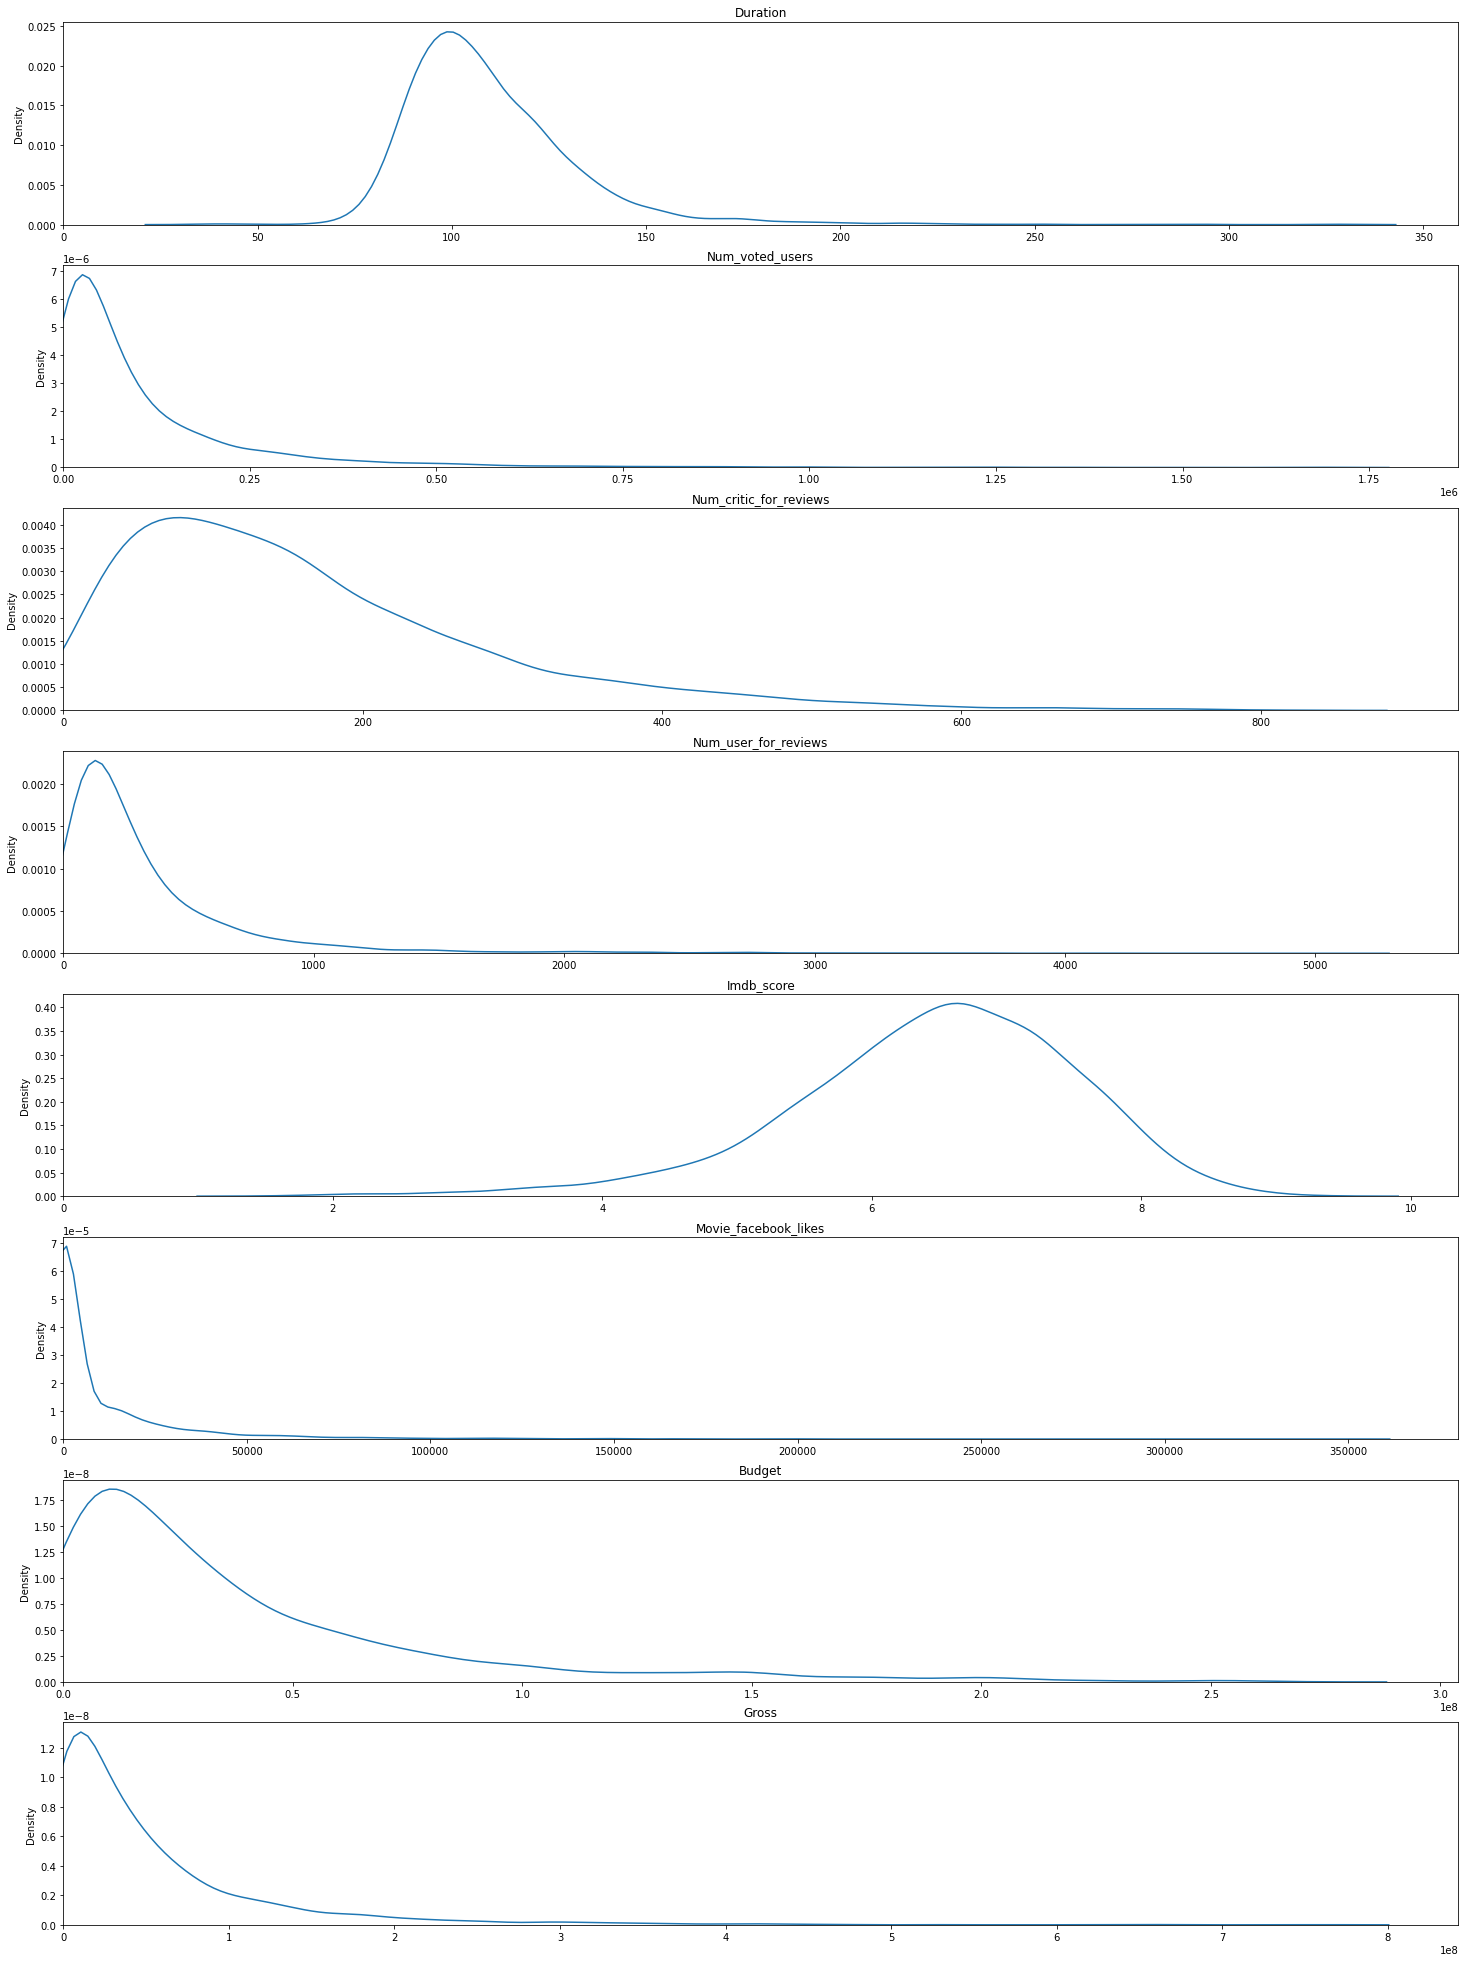

In [10]:
col_name_list = [col for col in list(feature_table.columns) if col not in ['movie_title', 'imdb_title_id', 'director_name']]
col_data_list = [feature_table[x] for x in col_name_list]


fig, ax = plt.subplots(len(col_data_list),1)
fig.set_size_inches(25, 35)

for x in range(len(col_name_list)):
    sns.kdeplot(np.array(col_data_list[x]), ax = ax[x]).set(title= col_name_list[x].capitalize(), xlim = (0))

plt.rcParams["figure.figsize"] = plt.rcParamsDefault["figure.figsize"]


<h2>Outlier onderzoek: </h2>

Hier kijken we naar de outliers in de data. 

Een outlier word hier gedefiniëerd als een datapunt wat 3 standaarddeviaties boven of onder het gemiddelde ligt.

In [11]:
# Temporary list that only contains columns which have numeral values, not names
lst = feature_table.drop(['movie_title','director_name','imdb_title_id'],axis=1)


# Calculate outliers per column, and print them
for col in lst:
    outliers = feature_table[feature_table[col] > feature_table[col].mean() + 3 * feature_table[col].std()]
    pd.set_option('display.max_rows', None)
    print(f'De column {col} bevat: {len(outliers)} outliers')
    

De column duration bevat: 60 outliers
De column num_voted_users bevat: 80 outliers
De column num_critic_for_reviews bevat: 61 outliers
De column num_user_for_reviews bevat: 80 outliers
De column imdb_score bevat: 0 outliers
De column movie_facebook_likes bevat: 86 outliers
De column budget bevat: 96 outliers
De column gross bevat: 85 outliers


<h2>Normaalverdeling meting:</h2>

Zoals we kunnen zien in onze densityplots, zijn onze features niet persé normaalverdeeld. Er zijn een aantal features waarbij dat nog in twijfel te trekken is, met name movie_facebook_likes, duration en gross. Dat gaan we nog nader onderzoeken.

Hier gebruiken we de normaltest van scipy stats om dat te controleren. Daar komen scores uit die inderdaad ondersteunen dat onze variabelen niet normaalverdeeld zijn. Een p score van hoger dan 0.05 is een indicatie voor een normaalverdeling.

Dat maakt het minder interessant om outliers te verwijderen, gezien het waarschijnlijk dan daadwerkelijk nuttige datapunten zijn.

In [12]:
print(stats.normaltest(feature_table['movie_facebook_likes']))
print(stats.normaltest(feature_table['duration']))
print(stats.normaltest(feature_table['gross']))

NormaltestResult(statistic=3712.504366370735, pvalue=0.0)
NormaltestResult(statistic=2061.1914809676896, pvalue=0.0)
NormaltestResult(statistic=2609.3259761327777, pvalue=0.0)


In [13]:
#Hier laten we zien hoe we de outliers zouden verwijderen
#Dit doen we niet omdat de data niet normaal verdeelt is, waardoor de outliers ook niet veel zeggen
print(feature_table.count())
Q1 = feature_table.quantile(0.25)
Q3 = feature_table.quantile(0.75)
IQR = Q3 - Q1
no_out = feature_table.copy(deep=True)

no_out = no_out[~((no_out < (Q1 - 1.5 * IQR)) |(no_out > (Q3 + 1.5 * IQR))).any(axis=1)]
print(no_out.count())


movie_title               3874
duration                  3874
imdb_title_id             3874
num_voted_users           3874
num_critic_for_reviews    3874
num_user_for_reviews      3874
imdb_score                3874
movie_facebook_likes      3874
budget                    3874
gross                     3874
director_name             3874
dtype: int64
movie_title               2872
duration                  2872
imdb_title_id             2872
num_voted_users           2872
num_critic_for_reviews    2872
num_user_for_reviews      2872
imdb_score                2872
movie_facebook_likes      2872
budget                    2872
gross                     2872
director_name             2872
dtype: int64


<ipython-input-13-f964cdd9e014>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  no_out = no_out[~((no_out < (Q1 - 1.5 * IQR)) |(no_out > (Q3 + 1.5 * IQR))).any(axis=1)]
<ipython-input-13-f964cdd9e014>:9: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  no_out = no_out[~((no_out < (Q1 - 1.5 * IQR)) |(no_out > (Q3 + 1.5 * IQR))).any(axis=1)]


<h1> Korte data-analyse </h1>

Hieronder doen we een aantal visualisaties om alvast wat inzicht te krijgen in eventuele correlaties tussen de data. Dit geeft een beetje en idee van hoe de data eruit ziet. We beginnen met een correlatiematrix, en zoomen dan in op bepaalde correlaties.

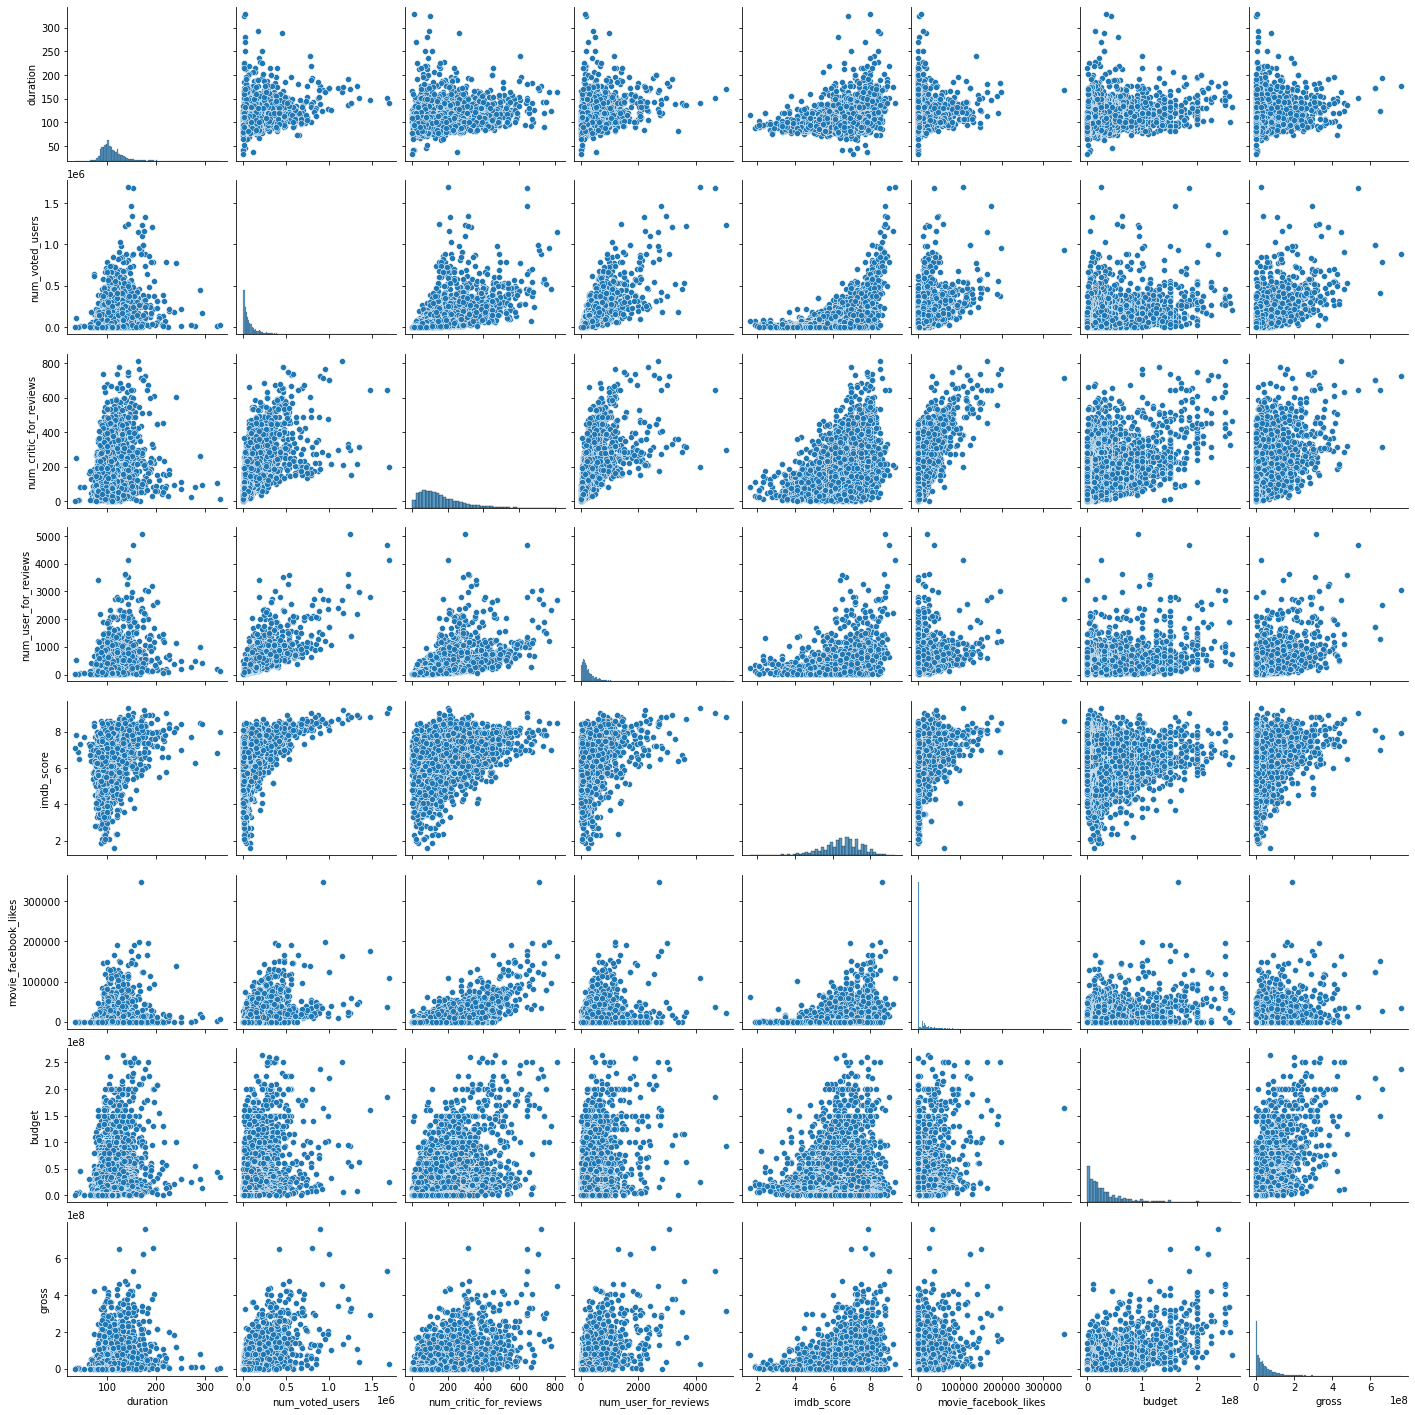

In [14]:
sns.pairplot(feature_table)

<h2> Correlatie IMDb Score vs Gross </h2>
Hier maken we een scatterplot om alvast te kijken naar de verhouding tussen imdb score en gross.

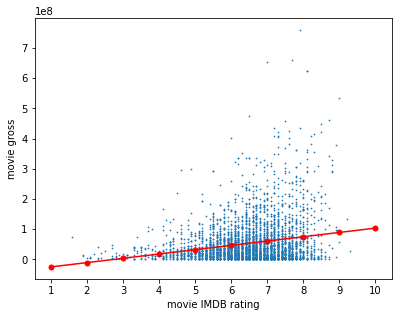

In [15]:
table = table.dropna()

x = table[['imdb_score']]
y = table[['gross']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie gross')

lm = linear_model.LinearRegression()
lm.fit(x, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))

plt.scatter(x, y, s = .5)
plt.show()


Je kunt hier zien dat er zeker een correlatie te vinden is en dus is het interessant om verder te onderzoeken hoe zich dit verhoudt en of we dit kunnen gebruiken om voorspellingen te doen.

<h2> Correlatie facebook likes vs Gross</h2>
Hier zien we dat de correlatie tussen facebook likes en gross er heel anders uit ziet. Ook interessant om nader te onderzoeken.

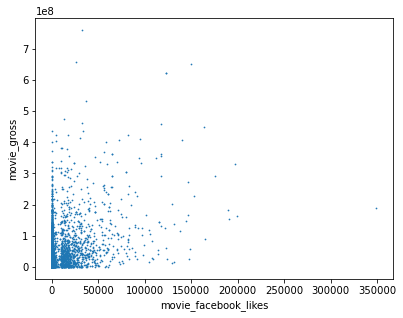

In [16]:
table = table.dropna()

x = table[['movie_facebook_likes']]
y = table[['gross']]

plt.xlabel('movie_facebook_likes')
plt.ylabel('movie_gross')

plt.scatter(x, y, s = .5)
plt.show()

<h2> Correlatie IMDb score vs Budget </h2>

Hier kijken we naar de correlatie tussen de IMDb score en het budget van de film. Er is duidelijk een lineare correlatie te herkennen.

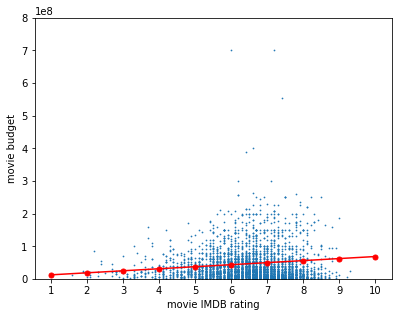

In [17]:
table = table.dropna()

x = table[['imdb_score']]
y = table[['budget']]

plt.xlabel('movie IMDB rating')
plt.ylabel('movie budget')


plt.ylim(0,800000000)

lm = linear_model.LinearRegression()
lm.fit(x, y)


pX = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])


plt.plot([1,2,3,4,5,6,7,8,9,10],lm.predict(pX),
        marker='.', markerfacecolor='red', markersize=10, color = 'red')
plt.xticks(np.arange(0, 11, 1.0))

plt.scatter(x, y, s = .5)
plt.show()

<h2> Table merge process </h2>



Voor dit project hebben wij een tweede dataset gevonden op Kaggle (https://www.kaggle.com/stefanoleone992/imdb-extensive-dataset) met IMDb data. Die gaan we in het onderstaande codeblock samenvoegen met de gegeven database.

Daarvoor moeten we een aantal dingen doen. De eerste stap is om in de 2e tabel de kolom "movie_facebook_likes" toe te voegen en te vullen met NaNs, dat maakt het samenvoegen van de twee tabellen makkelijker.

Vervolgens zorgen we ervoor dat beide tabellen voor dezelfde informatie ook dezelfde colomnamen gebruiken. 

We gebruiken de IMDb ID als index. In de gegeven database is dit een ID, maar in onze database is het een link waar de ID in zit. Die trimmen we om de ID te extraheren. 

Als we dat hebben gedaan voegen we de twee databases samen en verwijderen dubbele waardes.

In [18]:
table2.isnull().sum()

imdb_title_id                0
title                        0
original_title               0
year                         0
date_published               0
genre                        0
duration                     0
country                     64
language                   833
director                    87
writer                    1572
production_company        4455
actors                      69
description               2115
avg_vote                     0
votes                        0
budget                   62145
usa_gross_income         70529
worlwide_gross_income    54839
metascore                72550
reviews_from_users        7597
reviews_from_critics     11797
dtype: int64

In [19]:
def normalize_budget_gross():
    """the budget/gross of the second dataset uses a different format, we only keep the values already in USD"""

    def isnumber(x):
        try:
            float(x)
            return x
        except:
            return np.NaN

    table2['budget'] = table2['budget'].str.replace('$', '')
    table2['usa_gross_income'] = table2['usa_gross_income'].str.replace('$', '')
    table2['worlwide_gross_income'] = table2['worlwide_gross_income'].str.replace('$', '')


    table2['budget'] = table2['budget'].map(isnumber)
    table2['usa_gross_income'] = table2['usa_gross_income'].map(isnumber)
    table2['worlwide_gross_income'] = table2['worlwide_gross_income'].map(isnumber)



normalize_budget_gross()


#replace values with the value 0 in the column movie_facebook_likes with np.NaN, since no movie actually has 0 facebook likes
#it functions as a NULL value but screws with our data
table['movie_facebook_likes'] =  table['movie_facebook_likes'].replace(0, np.NaN)

<ipython-input-19-585ca09836fe>:11: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  table2['budget'] = table2['budget'].str.replace('$', '')
<ipython-input-19-585ca09836fe>:12: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  table2['usa_gross_income'] = table2['usa_gross_income'].str.replace('$', '')
<ipython-input-19-585ca09836fe>:13: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  table2['worlwide_gross_income'] = table2['worlwide_gross_income'].str.replace('$', '')


In [20]:
# the second data set has no facebook_likes so we create an empty column
table2['movie_facebook_likes'] = np.NaN

#trim both tables so we only have 
feature_table = table[['movie_title','duration', 'movie_imdb_link', 'num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews','imdb_score', 'movie_facebook_likes','budget', 'gross', 'director_name']]
feature_table2 = table2[['original_title', 'duration', 'imdb_title_id', 'votes', 'reviews_from_critics', 'reviews_from_users', 'avg_vote','movie_facebook_likes', 'budget','usa_gross_income','worlwide_gross_income', 'director' ]]


# change the movie_imdb_link to a imdb_title_id
feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]
feature_table = feature_table.rename(columns={"movie_imdb_link": "imdb_title_id"})

#change the names of the columns of the second table to corresponding collumn names of the first table
feature_table2 = feature_table2.rename(columns={"avg_vote": "imdb_score", 'original_title':'movie_title', 'votes':'num_voted_users', 'usa_gross_income':'US_gross','worlwide_gross_income':'worldwide_gross', 'reviews_from_critics': 'num_critic_for_reviews', 'reviews_from_users': 'num_user_for_reviews', 'director':'director_name'})
feature_table = feature_table.rename(columns={'gross': 'US_gross'})


#append table2 to table
new_df = feature_table.append(feature_table2)

#remove duplicates from the merged tables
new_df.drop_duplicates(subset ="imdb_title_id",
                     keep = 'first', inplace = True)


#cast all values in the  gross and budget columns to floats
new_df.US_gross = pd.to_numeric(new_df.US_gross)
new_df.worldwide_gross = pd.to_numeric(new_df.worldwide_gross)
new_df.budget = pd.to_numeric(new_df.budget)



<ipython-input-20-847cd0e8905c>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_table["movie_imdb_link"]= feature_table["movie_imdb_link"].str.split("/", n = 5, expand = True)[4]


In [21]:
len(new_df)

85918

<AxesSubplot:>

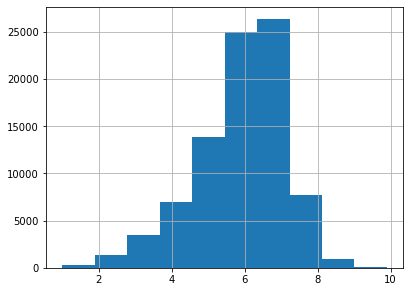

In [22]:
new_df['imdb_score'].hist()

<h2> 1. In hoeverre is de omzet van een film te voorspellen op basis van de populariteit op Facebook en IMDB? </h2>

In [41]:
#maak tijdelijk dataframe aan met alleen de kollomen die we gebruiken Gross voorspellend model
line_df = new_df[['movie_facebook_likes','imdb_score','US_gross']].copy(deep=True)

#drop all nans 
line_df = line_df.dropna()

# onafhankelijke variabelen zijn: imdb_score & movie_facebook_likes
# afhankelijke variabele is US_gross

#Hier maken we onderscheid tussen een train en test set. De size van de test set is 33% van het de complete set, en de training set is dus 67%
train_df, test_df = train_test_split(line_df, test_size = 0.33)

#Hier wordt het model gemaakt op basis van de eerder gemaakt xtrain en ytrain
regr = linear_model.LinearRegression().fit(train_df[['movie_facebook_likes','imdb_score']], train_df['US_gross'])

In [50]:
 # nu willen we het hierboven gemaakte model valideren door de test set in te laden in het eerder gemaakte model
# hiervan willen we de voorspellde waarden vergelijken met de waarden uit het dataframe
#ook berekenen we hier de RSME door de formule die gegeven staat op https://www.statisticshowto.com/probability-and-statistics/regression-analysis/rmse-root-mean-square-error/

predicted=0
verschil=0
results=[]
RMSE=0
for  index, row in test_df.iterrows(): 
    
    gross = row['US_gross']
    predicted = float(regr.predict([[row['movie_facebook_likes'],row['imdb_score']]]))
    verschil = row['US_gross'] - predicted
    #hier berekenen we: (verschil^2) / lengte van de set
    verschil_pwr = (verschil * verschil) / len(test_df.US_gross)

    #print(f'predicted gross: {predicted:,}, real gross: { gross:,}\nHet verschil is dus: {float(verschil):,}')

    results.append(verschil_pwr)
RSME= (sqrt(sum(results)))



75018262.21834797


<h2> 2. In hoeverre is de IMDB score van een film te voorspellen op basis van het budget en de opbrengst? </h2>

<h2> 3. Kunnen we logische klusters vinden van regisseurs die winstgevende films maken of regisseurs die vaak verliesgevende films maken? </h2>

In [25]:
director_df = new_df[['movie_title','director_name','budget', 'worldwide_gross']].copy()
director_df = director_df.dropna()
director_df["profit"] = director_df["worldwide_gross"] - director_df["budget"]
unique_directors = set(director_df['director_name'])


In [26]:
director_df.head()

,movie_title,director_name,budget,worldwide_gross,profit
165,Das Cabinet des Dr. Caligari,Robert Wiene,18000.000,8811.000,-9189.000
245,The Four Horsemen of the Apocalypse,Rex Ingram,800000.000,9183673.000,8383673.000
251,The Kid,Charles Chaplin,250000.000,26916.000,-223084.000
348,A Woman of Paris: A Drama of Fate,Charles Chaplin,351000.000,11233.000,-339767.000
415,The Gold Rush,Charles Chaplin,923000.000,26916.000,-896084.000


In [27]:
performance_list = [[ud,np.mean(director_df[director_df['director_name'] == ud]['profit']),np.min(director_df[director_df['director_name'] == ud]['profit']),np.max(director_df[director_df['director_name'] == ud]['profit']),len(director_df[director_df['director_name'] == ud]['profit'])]for ud in unique_directors]

<AxesSubplot:xlabel='min_profit', ylabel='max_profit'>

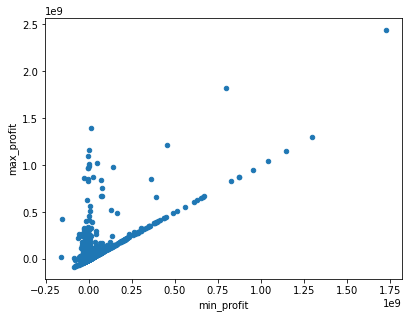

In [28]:
performance_df = pd.DataFrame(performance_list, columns=['director_name', 'mean_profit', 'min_profit','max_profit','number_of_movies'])
performance_df.plot.scatter('min_profit', 'max_profit')

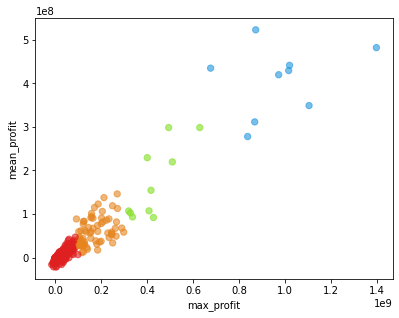

In [29]:

plot_df = performance_df[performance_df['number_of_movies']>=3]

#David Yates is too good at his job and fucks up the graph so shall be deleted
plot_df = plot_df[plot_df.director_name != 'David Yates']


kmeans = KMeans(n_clusters=4, random_state=0)
plot_df['cluster'] = kmeans.fit_predict(plot_df[['max_profit', 'mean_profit']])

centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

plot_df['cen_x'] = plot_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
plot_df['cen_y'] = plot_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})

colors = ['#DF2020', '#E6851F', '#2095DF', '#81DF20']
plot_df['c'] = plot_df.cluster.map({0:colors[0], 1:colors[2], 2:colors[1], 3:colors[3]})

plt.xlabel('max_profit')
plt.ylabel('mean_profit')
plt.scatter(plot_df.max_profit, plot_df.mean_profit, c=plot_df.c, alpha = 0.6, s=40)


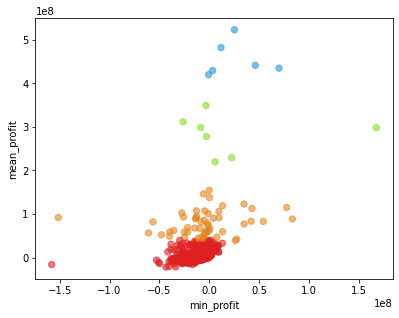

In [30]:
plot_df = performance_df[performance_df['number_of_movies']>=3]

#David Yates is too good at his job and fucks up the graph so shall be deleted
plot_df = plot_df[plot_df.director_name != 'David Yates']


kmeans = KMeans(n_clusters=4, random_state=0)
plot_df['cluster'] = kmeans.fit_predict(plot_df[['min_profit', 'mean_profit']])

centroids = kmeans.cluster_centers_
cen_x = [i[0] for i in centroids] 
cen_y = [i[1] for i in centroids]

plot_df['cen_x'] = plot_df.cluster.map({0:cen_x[0], 1:cen_x[1], 2:cen_x[2], 3:cen_x[3]})
plot_df['cen_y'] = plot_df.cluster.map({0:cen_y[0], 1:cen_y[1], 2:cen_y[2], 3:cen_y[3]})

colors = ['#DF2020', '#E6851F', '#2095DF', '#81DF20']
plot_df['c'] = plot_df.cluster.map({0:colors[0], 1:colors[2], 2:colors[1], 3:colors[3]})

plt.xlabel('min_profit')
plt.ylabel('mean_profit')
plt.scatter(plot_df.min_profit, plot_df.mean_profit, c=plot_df.c, alpha = 0.6, s=40)

In [31]:
performance_df.sort_values('mean_profit', ascending = False)[performance_df.sort_values('mean_profit', ascending = False)['number_of_movies']>=3]

,director_name,mean_profit,min_profit,max_profit,number_of_movies
3174,David Yates,768686968.667,454855901.000,1217166497.000,3
3037,Jake Kasdan,523001079.667,25325009.000,872102237.000,3
5,Jon Favreau,482071387.667,11822325.000,1396963790.000,3
3568,Todd Phillips,441495302.000,46234523.000,1019251311.000,3
1154,David Leitch,434955046.333,70014025.000,675794179.000,3
3435,Rian Johnson,429415187.667,3472579.000,1015540187.000,3
2757,Jon Watts,419830045.250,-656342.000,971927996.000,4
2096,Bill Condon,349044988.400,-3256555.000,1104064380.000,5
1903,Guy Ritchie,311513604.667,-26324934.000,867693953.000,3
2110,Justin Lin,298514075.000,-8503008.000,628680968.000,3


In [32]:
df_copy = new_df[['movie_facebook_likes','imdb_score','US_gross']].copy(deep=True)

fig = px.scatter_3d(df_copy, x='movie_facebook_likes', y='US_gross', z='imdb_score')
fig.show()

NameError: name 'px' is not defined

<h2> Kun je voorspellen of een film winst of verlies heeft gemaakt op basis van variabelen in de DB: </h2>

In [ ]:
prof_df = new_df.copy()
prof_df = prof_df[prof_df['budget'].notna()]
prof_df = prof_df[prof_df['worldwide_gross'].notna()]

prof_df["profit"] = prof_df["worldwide_gross"] - prof_df["budget"]

#heeft de film winst gemaakt 1 of 0
prof_df['profit_positive'] = np.where(prof_df['profit']> 0, 1, 0)

#movie_facebook_likes heeft wel degelijk een correlatie met de profit, maar helaas heeft de kolom te veel NaN waardes om te gebruiken
prof_df = prof_df[['duration','num_voted_users', 'num_critic_for_reviews', 'num_user_for_reviews', 'imdb_score', 'budget', 'profit_positive']]

In [ ]:
#helaas heeft niks een erg sterke correlatie met de profit, maar het is genoeg om een model te maken dat beter is dan puur gokken
prof_df.corr(method = 'pearson')

,duration,num_voted_users,num_critic_for_reviews,num_user_for_reviews,imdb_score,budget,profit_positive
duration,1.000,0.241,0.221,0.226,0.344,0.249,0.130
num_voted_users,0.241,1.000,0.768,0.736,0.346,0.569,0.340
num_critic_for_reviews,0.221,0.768,1.000,0.690,0.325,0.560,0.351
num_user_for_reviews,0.226,0.736,0.690,1.000,0.208,0.589,0.261
imdb_score,0.344,0.346,0.325,0.208,1.000,0.105,0.204
budget,0.249,0.569,0.560,0.589,0.105,1.000,0.222
profit_positive,0.130,0.340,0.351,0.261,0.204,0.222,1.000


In [ ]:
prof_df = prof_df.dropna()

In [ ]:
def logistic_regression(sets):
    

    logreg = LogisticRegression()
    logreg.fit(sets['X_train'], sets['y_train'].values.ravel())
    y_pred = logreg.predict(sets['X_test'])

    return metrics.accuracy_score(sets['y_test'], y_pred)


def decision_tree(sets, criterion, max_depth):
    
    clf = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth)

    clf = clf.fit(sets['X_train'],sets['y_train'].values.ravel())

    y_pred = clf.predict(sets['X_test'])

    return metrics.accuracy_score(sets['y_test'], y_pred)



def random_forests(sets,criterion, max_depth):
    
    rclf = RandomForestClassifier(criterion = criterion, max_depth=max_depth)
    rclf.fit(sets['X_train'], sets['y_train'].values.ravel())

    y_pred = rclf.predict(sets['X_test'])
    return metrics.accuracy_score(sets['y_test'], y_pred)


def support_vectors(sets):
 
    svclf = svm.SVC()
    svclf.fit(sets['X_train'], sets['y_train'].values.ravel())
    y_pred = svclf.predict(sets['X_test'])
    
    return metrics.accuracy_score(sets['y_test'], y_pred)

def k_nearest_neighbors(sets,k):
    
    from sklearn.neighbors import KNeighborsClassifier
    neigh = KNeighborsClassifier(n_neighbors=k)
    neigh.fit(sets['X_train'], sets['y_train'].values.ravel())
    y_pred = neigh.predict(sets['X_test'])
    
    return metrics.accuracy_score(sets['y_test'], y_pred)


In [ ]:
def test_ml_models(random_state_i, X,y):
    
    vc = prof_df['profit_positive'].value_counts()

    #er zijn meer films die geen winst hebben gemaakt in onze dataset, 61%
    base_accuracy = vc[0]/(vc[0] + vc[1])

    lr_list = []
    dt_list = []
    rf_list = []
    sv_list = []
    knn_list = []

    for i in range(random_state_i):

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)

        
        sets = {'X_train': X_train, 'y_train':y_train, 'X_test': X_test, 'y_test': y_test}

        lr = logistic_regression(sets)
        dt = decision_tree(sets, 'gini', 5)
        rf = random_forests(sets,'gini', 14)
        sv = support_vectors(sets)
        knn = k_nearest_neighbors(sets,2)
        

        lr_list.append(lr)
        dt_list.append(dt)
        rf_list.append(rf)
        sv_list.append(sv)
        knn_list.append(knn)  
        
        
        lr_mean = np.mean(lr_list)
        dt_mean = np.mean(dt_list)
        rf_mean = np.mean(rf_list)
        sv_mean = np.mean(sv_list)
        knn_mean = np.mean(knn_list)
        
    models = ['Base Chance','Support Vector Machines','Logistic Regression','K-Nearest Neighbors', 'Decision Tree', 'Random Forests']
    x_pos = np.arange(len(models))
    CTEs = [baseline,sv_mean,lr_mean,knn_mean, dt_mean, rf_mean]
    error = [0,np.std(sv_list),np.std(lr_list),np.std(knn_list), np.std(dt_list), np.std(rf_list)]
    fig, ax = plt.subplots()
    ax.bar(x_pos, CTEs, yerr=error, align='center', alpha=0.5, ecolor='black', capsize=10)
    ax.set_ylabel('Chance of correctly classifying a movie')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models)
    ax.set_title('Deciding the best ML model for predicting profitable movies')
    ax.yaxis.grid(True)

    # Save the figure and show
    plt.tight_layout()
    plt.xticks(rotation=360-25)
    plt.show()
    
    return {'base_accuracy': base_accuracy, 'lr_accuracy':lr_mean,'dt_accuracy':dt_mean, 'rf_accuracy':rf_mean, 'sv_accuracy':sv_mean, 'knn_accuracy':knn_mean}

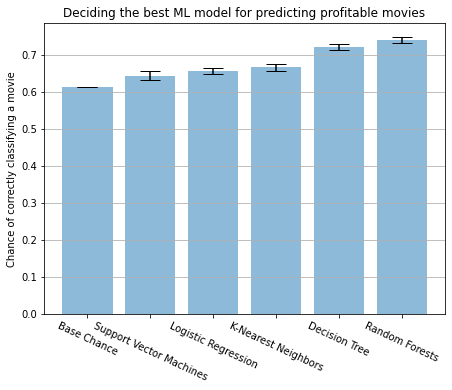

{'base_accuracy': 0.613265306122449,
 'lr_accuracy': 0.6577891156462585,
 'dt_accuracy': 0.7228571428571428,
 'rf_accuracy': 0.7410884353741496,
 'sv_accuracy': 0.6443537414965985,
 'knn_accuracy': 0.6665646258503402}

In [ ]:
# wat is de nauwkeurigheid van verschillende ML modellen als we alle kolommen met een positieve correlatie met de profit
# en genoeg waarden gebruiken
test_ml_models(20, prof_df.loc[:, prof_df.columns != 'profit_positive'], prof_df.loc[:, prof_df.columns == 'profit_positive'])

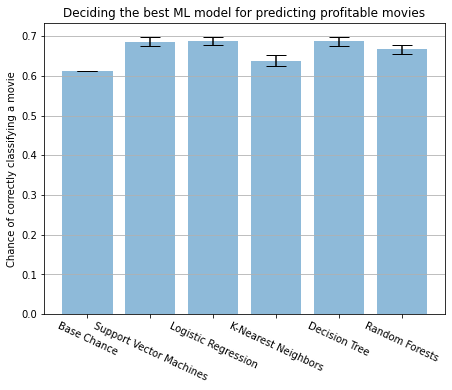

{'base_accuracy': 0.613265306122449,
 'lr_accuracy': 0.688299319727891,
 'dt_accuracy': 0.6876870748299319,
 'rf_accuracy': 0.667482993197279,
 'sv_accuracy': 0.6870068027210884,
 'knn_accuracy': 0.63921768707483}

In [ ]:
# krijgen we een hogere nauwkeurigheid als we alleen de sterkst correlerende kolom (met de profit) gebruiken?
test_ml_models(20, prof_df[['num_critic_for_reviews']], prof_df.loc[:, prof_df.columns == 'profit_positive'])

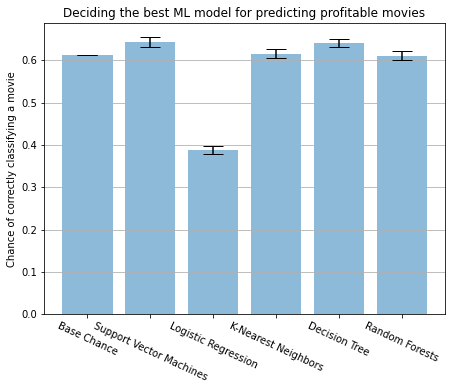

{'base_accuracy': 0.613265306122449,
 'lr_accuracy': 0.38775510204081626,
 'dt_accuracy': 0.64078231292517,
 'rf_accuracy': 0.6115646258503402,
 'sv_accuracy': 0.6441496598639455,
 'knn_accuracy': 0.6160884353741497}

In [ ]:
# wat als we alleen maar kolommen gebruiken met informatie die we hebben voordat de film uitkomt. kunnen we dan accuraat
# voorspellen of een film winstgevend is?
test_ml_models(20, prof_df[['duration', 'budget']], prof_df.loc[:, prof_df.columns == 'profit_positive'])

<h4> Conclusie: </h4>

De basis kans om een film succesvol te classificeren als winstgevend/niet winstgevend is ~61% omdat we werken met een licht 'lopsided' dataset. Als we gebruik maken van alle discrete/continue variabelen, waar we genoeg data voor hebben, dan is random forests het machine learning model dat de beste voorspelling kan maken, met ~74% kans op een goede classificatie. Sommige van de machine learning modellen werken beter op een X-dataset met minder kolommen. Als we alleen maar kijken naar de kolom met de sterkste correlatie met winst dan zien we dat de nauwkeurigheid van de voorspelling omhoog gaat voor de support vector machines en logistic regression modellen. Voor k-nearest neighbours, decision trees en random forests gaat de nauwkeurigheid echter naar beneden.

Het proberen te voorspellen of een film winstgevend zal zijn op basis van ALLEEN variabelen die we al van te voren weten (duration, budget) werkt een stuk slechter. De beste modellen daarvoor zijn in dit geval support vector machines en random forests, maar deze hebben maar een nauwkeurigheid van ~64%.